In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error


# The code begins by importing libraries necessary for handling data (pandas, pathlib), 
# visualizing it (matplotlib, hvplot), and performing machine learning (KMeans, StandardScaler). 
# It also includes functions for analyzing time series data (seasonal_decompose) 
# and evaluating models (mean_squared_error).


In [2]:
csv_H8 = Path("Assets and Liabilities of Commercial Banks.csv")
as_Liab_df = pd.read_csv(csv_H8, skiprows=0)
as_Liab_df.columns = as_Liab_df.columns.str.strip().str.lower().str.replace(' ', '_')
as_Liab_df.dropna()

csv_H6 = Path("Money Stock Measures.csv")
money_st_df = pd.read_csv(csv_H6, skiprows=0)
money_st_df.columns = money_st_df.columns.str.strip().str.lower().str.replace(' ', '_')
money_st_df.dropna()

csv_G19 = Path("Consumer Credit.csv")
credit_Cr_df = pd.read_csv(csv_G19, skiprows=0)
credit_Cr_df.columns = credit_Cr_df.columns.str.strip().str.lower().str.replace(' ', '_')
credit_Cr_df.dropna()

merged_df = pd.merge(as_Liab_df, money_st_df, on='series_description', how='inner')
final_df = pd.merge(merged_df, credit_Cr_df, on='series_description', how='inner')
final_df.dropna()

# This code reads in three CSV files (Assets and Liabilities, Money Stock Measures, Consumer Credit) and processes them.
# The columns are cleaned by stripping whitespace, converting to lowercase, and replacing spaces with underscores.
# The dataframes are then merged on the 'series_description' column using inner joins, and missing values are dropped at each step.


,series_description,"bank_credit,_all_commercial_banks,_not_seasonally_adjusted","securities_in_bank_credit,_all_commercial_banks,_not_seasonally_adjusted","treasury_and_agency_securities,_all_commercial_banks,_not_seasonally_adjusted","other_securities,_all_commercial_banks,_not_seasonally_adjusted","real_estate_loans,_all_commercial_banks,_not_seasonally_adjusted","total_assets,_all_commercial_banks,_not_seasonally_adjusted",m1;_not_seasonally_adjusted,m2;_not_seasonally_adjusted,currency;_not_seasonally_adjusted,...,"nonrevolving_consumer_credit_owned_by_depository_institutions,_not_seasonally_adjusted_flow,_monthly_rate","nonrevolving_consumer_credit_securitized_by_depository_institutions,_not_seasonally_adjusted_flow,_monthly_rate","nonrevolving_consumer_credit_owned_and_securitized_by_finance_companies,_not_seasonally_adjusted_flow,_monthly_rate","nonrevolving_consumer_credit_owned_by_finance_companies,_not_seasonally_adjusted_flow,_monthly_rate","nonrevolving_consumer_credit_securitized_by_finance_companies,_not_seasonally_adjusted_flow,_monthly_rate","nonrevolving_consumer_credit_owned_by_credit_unions,_not_seasonally_adjusted_flow,_monthly_rate","nonrevolving_consumer_credit_owned_by_federal_government,_not_seasonally_adjusted_flow,_monthly_rate","nonrevolving_consumer_credit_owned_by_nonprofit_and_educational_institutions,_not_seasonally_adjusted_flow,_monthly_rate","nonrevolving_consumer_credit_owned_and_securitized_by_nonfinancial_business,_not_seasonally_adjusted_flow,_monthly_rate","nonrevolving_consumer_credit_owned_by_nonfinancial_business,_not_seasonally_adjusted_flow,_monthly_rate"
0,2019-01,13182845.3,3544903.5,2715544.1,829359.5,4423221.8,16990230.5,3748.5,14423.8,1623.6,...,4332.04,-248.04,-480.05,-480.05,0,662.57,26715.81,-311.72,95.87,95.87
1,2019-02,13186105.6,3544991.1,2716072.0,828919.1,4425163.1,17045684.5,3705.1,14401.9,1628.5,...,124.09,-223.48,-2687.83,-2687.83,0,-777.69,5742.25,-265.23,-49.10,-49.10
2,2019-03,13221065.4,3559334.6,2732143.5,827191.1,4435195.9,17104931.2,3757.3,14572.5,1641.6,...,2871.89,-245.65,-58.63,-58.63,0,481.85,840.92,-418.73,-67.28,-67.28
3,2019-04,13307387.6,3607067.6,2769758.4,837309.2,4450201.8,17065992.8,3823.8,14623.0,1649.3,...,6712.60,-210.09,648.50,648.50,0,2835.56,796.40,-384.63,-27.60,-27.60
4,2019-05,13370639.4,3620906.3,2789156.5,831749.8,4477501.5,17130859.5,3791.3,14575.0,1655.6,...,4917.22,-215.26,2325.09,2325.09,0,-1051.25,5040.43,-318.98,-19.58,-19.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2023-09,17255552.4,5059419.2,4028562.9,1030856.3,5503144.9,22831239.0,18134.1,20668.7,2239.4,...,296.36,425.61,2904.75,2904.75,0,1840.07,6177.72,338.09,28.42,28.42
57,2023-10,17251037.5,5014583.8,3995048.8,1019534.9,5512329.9,22898808.5,18020.9,20627.9,2237.6,...,-3334.49,4137.12,2619.65,2619.65,0,1004.45,-1066.71,-228.15,-14.47,-14.47
58,2023-11,17304961.1,5039373.3,4025278.4,1014095.0,5525497.9,23098779.7,18016.7,20701.0,2241.0,...,-3197.50,4226.59,2601.01,2601.01,0,-1955.00,359.32,-236.55,-21.65,-21.65
59,2023-12,17436808.3,5101661.9,4085120.8,1016541.2,5536796.4,23326053.9,18113.3,20855.2,2247.7,...,-14619.02,4064.45,2930.30,2930.30,0,-1225.09,-169.61,-91.63,-43.14,-43.14


In [3]:
final_df.rename(columns={'series_description': 'date'}, inplace=True)

column_mapping = {
    'bank_credit,_all_commercial_banks,_not_seasonally_adjusted': 'bank_credit',
    'securities_in_bank_credit,_all_commercial_banks,_not_seasonally_adjusted': 'securities_in_bank_credit',
    'treasury_and_agency_securities,_all_commercial_banks,_not_seasonally_adjusted': 'treasury_agency_securities',
    'other_securities,_all_commercial_banks,_not_seasonally_adjusted': 'other_securities',
    'real_estate_loans,_all_commercial_banks,_not_seasonally_adjusted': 'real_estate_loans',
    'total_assets,_all_commercial_banks,_not_seasonally_adjusted': 'total_assets',
    'currency;_seasonally_adjusted': 'currency_sa',
    'demand_deposits;_seasonally_adjusted': 'demand_deposits_sa',
    'monetary_base;_currency_in_circulation;_not_seasonally_adjusted': 'monetary_base_currency_nsa',
    'monetary_base;_total;_not_seasonally_adjusted': 'monetary_base_total_nsa',
    'percent_change_of_total_consumer_credit,_seasonally_adjusted_at_an_annual_rate': 'pct_change_consumer_credit_sa',
    'total_consumer_credit_owned_and_securitized,_seasonally_adjusted_level': 'consumer_credit_owned_securitized_sa',
    'total_consumer_credit_owned_by_nonfinancial_business,_not_seasonally_adjusted_level': 'consumer_credit_nonfinancial_owned_nsa',
    'total_consumer_credit_securitized_by_nonfinancial_business,_not_seasonally_adjusted_level': 'consumer_credit_nonfinancial_securitized_nsa',
    'total_consumer_credit_owned_by_credit_unions,_not_seasonally_adjusted_level': 'consumer_credit_credit_unions_owned_nsa',
}

final_df.rename(columns=column_mapping, inplace=True)

columns_to_keep = [
    'date',
    'bank_credit',
    'securities_in_bank_credit',
    'treasury_agency_securities',
    'other_securities',
    'real_estate_loans',
    'total_assets',
    'currency_sa',
    'demand_deposits_sa',
    'monetary_base_currency_nsa',
    'monetary_base_total_nsa',
    'pct_change_consumer_credit_sa',
    'consumer_credit_owned_securitized_sa',
    'consumer_credit_nonfinancial_owned_nsa',
    'consumer_credit_nonfinancial_securitized_nsa',
    'consumer_credit_credit_unions_owned_nsa'
]

final_df = final_df[columns_to_keep]
final_df['date'] = pd.to_datetime(final_df['date'], format='%Y-%m')

final_df

# This code performs the following:
# 1. Renames the 'series_description' column to 'date'.
# 2. Maps long column names to more concise, readable ones using a dictionary.
# 3. Selects specific columns to keep for further analysis.
# 4. Converts the 'date' column to a datetime format (year-month).
# The final dataframe is cleaned and structured for time series analysis or other applications.


,date,bank_credit,securities_in_bank_credit,treasury_agency_securities,other_securities,real_estate_loans,total_assets,currency_sa,demand_deposits_sa,monetary_base_currency_nsa,monetary_base_total_nsa,pct_change_consumer_credit_sa,consumer_credit_owned_securitized_sa,consumer_credit_nonfinancial_owned_nsa,consumer_credit_nonfinancial_securitized_nsa,consumer_credit_credit_unions_owned_nsa
0,2019-01-01,13182845.3,3544903.5,2715544.1,829359.5,4423221.8,16990230.5,1629.5,1481.0,1707.8,3346.9,5.95,4026910.98,36019.72,0,481454.25
1,2019-02-01,13186105.6,3544991.1,2716072.0,828919.1,4425163.1,17045684.5,1635.3,1488.2,1708.2,3353.5,3.95,4040157.51,35518.03,0,480157.91
2,2019-03-01,13221065.4,3559334.6,2732143.5,827191.1,4435195.9,17104931.2,1640.3,1462.1,1720.2,3381.5,3.54,4052074.40,35197.38,0,480787.97
3,2019-04-01,13307387.6,3607067.6,2769758.4,837309.2,4450201.8,17065992.8,1646.3,1481.0,1727.2,3286.7,5.16,4069488.87,35109.26,0,483632.30
4,2019-05-01,13370639.4,3620906.3,2789156.5,831749.8,4477501.5,17130859.5,1650.9,1484.4,1733.2,3244.5,3.82,4082449.85,35208.25,0,483653.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2023-09-01,17255552.4,5059419.2,4028562.9,1030856.3,5503144.9,22831239.0,2241.5,4929.1,2327.7,5567.3,2.08,4991349.60,35087.52,0,661435.27
57,2023-10-01,17251037.5,5014583.8,3995048.8,1019534.9,5512329.9,22898808.5,2243.6,4950.7,2324.9,5601.3,2.26,5000737.39,35109.07,0,663516.21
58,2023-11-01,17304961.1,5039373.3,4025278.4,1014095.0,5525497.9,23098779.7,2246.6,4949.3,2328.0,5731.5,4.38,5018975.81,35548.86,0,662280.29
59,2023-12-01,17436808.3,5101661.9,4085120.8,1016541.2,5536796.4,23326053.9,2249.8,5008.7,2335.4,5827.4,1.13,5023699.47,35777.78,0,662586.72


In [5]:
final_df.to_csv('output data/final_data.csv', index=False)


In [4]:
numeric_df = final_df.select_dtypes(include='number')
numeric_df = numeric_df.dropna()  
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)
scaled_df = pd.DataFrame(scaled_data, columns=numeric_df.columns, index=numeric_df.index)

# This code does the following:
# 1. Selects only the numeric columns from the final dataframe.
# 2. Drops any rows containing missing values from the numeric dataframe.
# 3. Standardizes the numeric data using `StandardScaler` to scale features (mean=0, variance=1).
# 4. Converts the scaled data back into a pandas DataFrame, keeping the original column names and index.


In [5]:
inertia = []

k = list(range(1, 11))

for i in k:
    k_model = KMeans(n_clusters=i, random_state=2)
    k_model.fit(scaled_df)
    inertia.append(k_model.inertia_)

elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

df_elbow.hvplot.line(x='k', y='inertia', title='Elbow Curve', xlabel='Number of clusters (k)', ylabel='Inertia')

# This code performs the following:
# 1. Initializes an empty list `inertia` to store the inertia values for each k-means clustering model.
# 2. Defines a range of k values (number of clusters) from 1 to 10.
# 3. Runs k-means clustering for each k value and records the inertia (a measure of how well the data is clustered).
# 4. Creates a dataframe `df_elbow` with k values and their corresponding inertia values.
# 5. Plots an Elbow Curve using `hvplot` to visualize the inertia as a function of the number of clusters, helping to identify the optimal number of clusters.


:Curve   [k]   (inertia)

In [6]:
model = KMeans(n_clusters=4, random_state=1)
model.fit(scaled_df)
k_lower = model.predict(scaled_df)
bank_predictions_df = scaled_df.copy()
bank_predictions_df['clusters_lower'] = k_lower


# 1. Creates a KMeans model with 4 clusters and a fixed random state for reproducibility.
# 2. Fits the model to the scaled data.


In [7]:
print(bank_predictions_df.columns)

Index(['bank_credit', 'securities_in_bank_credit',
       'treasury_agency_securities', 'other_securities', 'real_estate_loans',
       'total_assets', 'currency_sa', 'demand_deposits_sa',
       'monetary_base_currency_nsa', 'monetary_base_total_nsa',
       'pct_change_consumer_credit_sa', 'consumer_credit_owned_securitized_sa',
       'consumer_credit_nonfinancial_owned_nsa',
       'consumer_credit_nonfinancial_securitized_nsa',
       'consumer_credit_credit_unions_owned_nsa', 'clusters_lower'],
      dtype='object')


In [8]:
bank_predictions_df.hvplot.scatter(
    x="monetary_base_total_nsa",
    y="total_assets",
    by="clusters_lower"
).opts(yformatter="%.0f")

:NdOverlay   [clusters_lower]
   :Scatter   [monetary_base_total_nsa]   (total_assets)

In [9]:
bank_predictions_df.hvplot.scatter(
    x="total_assets",
    y="demand_deposits_sa",
    by="clusters_lower"
).opts(yformatter="%.0f")

# 1. The first plot shows 'monetary_base_total_nsa' vs. 'total_assets', with points colored by the 'clusters_lower' column.
# 2. The second plot shows 'total_assets' vs. 'demand_deposits_sa', again coloring points by their cluster assignments.
# 3. Both plots format the y-axis with no decimal places using the 'yformatter' option.


:NdOverlay   [clusters_lower]
   :Scatter   [total_assets]   (demand_deposits_sa)

In [10]:
month_decomp = final_df
month_decomp.rename({'date': 'month'}, axis=1, inplace=True)
month_decomp['month'] = pd.to_datetime(month_decomp['month'])
month_decomp.set_index(['month'], inplace=True)
month_decomp

# 1. Creates a copy of the final dataframe and assigns it to `month_decomp`.
# 2. Renames the 'date' column to 'month'.
# 3. Converts the 'month' column to a datetime format for proper time series handling.



,bank_credit,securities_in_bank_credit,treasury_agency_securities,other_securities,real_estate_loans,total_assets,currency_sa,demand_deposits_sa,monetary_base_currency_nsa,monetary_base_total_nsa,pct_change_consumer_credit_sa,consumer_credit_owned_securitized_sa,consumer_credit_nonfinancial_owned_nsa,consumer_credit_nonfinancial_securitized_nsa,consumer_credit_credit_unions_owned_nsa
month,,,,,,,,,,,,,,,
2019-01-01,13182845.3,3544903.5,2715544.1,829359.5,4423221.8,16990230.5,1629.5,1481.0,1707.8,3346.9,5.95,4026910.98,36019.72,0,481454.25
2019-02-01,13186105.6,3544991.1,2716072.0,828919.1,4425163.1,17045684.5,1635.3,1488.2,1708.2,3353.5,3.95,4040157.51,35518.03,0,480157.91
2019-03-01,13221065.4,3559334.6,2732143.5,827191.1,4435195.9,17104931.2,1640.3,1462.1,1720.2,3381.5,3.54,4052074.40,35197.38,0,480787.97
2019-04-01,13307387.6,3607067.6,2769758.4,837309.2,4450201.8,17065992.8,1646.3,1481.0,1727.2,3286.7,5.16,4069488.87,35109.26,0,483632.30
2019-05-01,13370639.4,3620906.3,2789156.5,831749.8,4477501.5,17130859.5,1650.9,1484.4,1733.2,3244.5,3.82,4082449.85,35208.25,0,483653.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,17255552.4,5059419.2,4028562.9,1030856.3,5503144.9,22831239.0,2241.5,4929.1,2327.7,5567.3,2.08,4991349.60,35087.52,0,661435.27
2023-10-01,17251037.5,5014583.8,3995048.8,1019534.9,5512329.9,22898808.5,2243.6,4950.7,2324.9,5601.3,2.26,5000737.39,35109.07,0,663516.21
2023-11-01,17304961.1,5039373.3,4025278.4,1014095.0,5525497.9,23098779.7,2246.6,4949.3,2328.0,5731.5,4.38,5018975.81,35548.86,0,662280.29


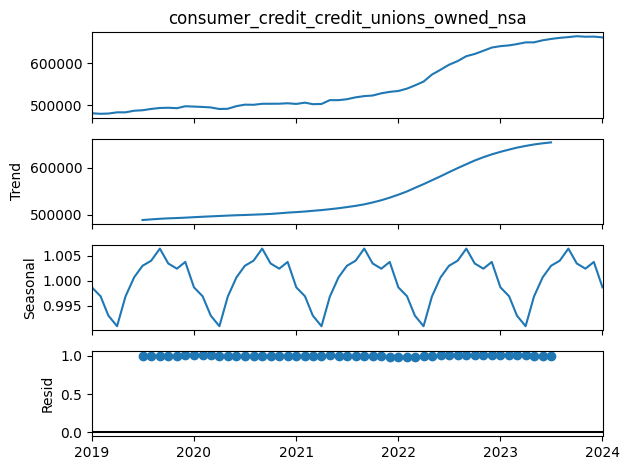

In [12]:
components =seasonal_decompose(month_decomp['consumer_credit_credit_unions_owned_nsa'], model='multiplicative')
components.plot()
plt.show()